### Imports

In [1]:
import pandas as pd
import numpy as np

from xgboost import XGBRegressor
import time
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
from sklearn.ensemble import StackingRegressor, VotingRegressor
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

### Data load

In [54]:
data_path_train = "data/df_train.csv"

df_train = pd.read_csv(data_path_train)
df_train = df_train.drop(columns=['BsmtHalfBath', 'PoolQC_Fa', 'Utilities_NoSeWa', 'PoolQC_Gd', 'BsmtFinSF2'])  # low correlation features

df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
MSSubClass,1460.0,56.897260,42.300571,20.000000,20.000000,50.000000,70.000000,190.000000
MSZoning,1460.0,181782.263881,22935.777066,127035.234484,190160.409288,191083.315173,191233.328298,212190.396173
LotFrontage,1460.0,57.623288,34.664304,0.000000,42.000000,63.000000,79.000000,313.000000
LotArea,1460.0,10516.828082,9981.264932,1300.000000,7553.500000,9478.500000,11601.500000,215245.000000
LotConfig,1460.0,180684.289342,10273.395580,171965.477367,176192.888970,177369.498778,178489.289614,222245.584865
...,...,...,...,...,...,...,...,...
Fence_MnPrv,1460.0,0.107534,0.309897,0.000000,0.000000,0.000000,0.000000,1.000000
Fence_MnWw,1460.0,0.007534,0.086502,0.000000,0.000000,0.000000,0.000000,1.000000
MiscFeature_Othr,1460.0,0.001370,0.036999,0.000000,0.000000,0.000000,0.000000,1.000000
MiscFeature_Shed,1460.0,0.033562,0.180160,0.000000,0.000000,0.000000,0.000000,1.000000


In [55]:
target_column = 'SalePrice'
X = df_train.drop(columns=[target_column])
y = df_train[target_column]
print(f"Target column '{target_column}' found. Shape: X={X.shape}, y={y.shape}")

numeric_cols = df_train.select_dtypes(include=[np.number]).columns.tolist()

Target column 'SalePrice' found. Shape: X=(1460, 93), y=(1460,)


In [68]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

### Feature selection

In [69]:
def feature_selection_pipelines():
    """
    Multiple feature selection pipelines for comparison
    """
    pipelines = {}
    
    # 1. Pipeline with SelectKBest + StandardScaler + XGBoost
    pipelines['kbest_xgb'] = Pipeline([
        ('scaler', StandardScaler()),
        ("feature_selection", SelectKBest(score_func=f_regression)),
        ("model", XGBRegressor(
            objective="reg:squarederror",
            random_state=42,
            tree_method="hist",
            n_jobs=-1
        ))
    ])
    
    # 2. Pipeline with PCA + Random Forest
    pipelines['pca_rf'] = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=0.95, random_state=42)),  # keeping 95% of variance
        ('model', RandomForestRegressor(random_state=42, n_jobs=-1))
    ])
    
    # 3. Pipeline with Gradient Boosting
    pipelines['gbr'] = Pipeline([
        ('scaler', StandardScaler()),
        ('selector', SelectKBest(f_regression, k=40)),
        ('model', GradientBoostingRegressor(random_state=42))
    ])
    
    # 4. Pipeline with Ridge Regression
    pipelines['ridge'] = Pipeline([
        ('scaler', StandardScaler()),
        ('model', Ridge(random_state=42))
    ])
    
    # 5. Pipeline with Lasso
    pipelines['lasso'] = Pipeline([
        ('scaler', StandardScaler()),
        ('model', Lasso(random_state=42))
    ])
    
    return pipelines

In [70]:
pipelines = feature_selection_pipelines()

### Parameter grids

In [71]:
def get_param_grids():
    """
    Parameter grids for different models
    """
    param_grids = {}
    
    # XGBoost with SelectKBest
    param_grids['kbest_xgb'] = {
    "feature_selection__k": [30, 40, 50],
    "model__n_estimators": [500, 800],
    "model__max_depth": [3, 4, 6],
    "model__learning_rate": [0.03, 0.05],
    "model__subsample": [0.8, 1.0],
    "model__colsample_bytree": [0.8, 1.0],
    "model__reg_alpha": [0.0, 0.1],
    "model__reg_lambda": [1.0, 1.5]
}
    
    # Random Forest with PCA
    param_grids['pca_rf'] = {
        'pca__n_components': [0.85, 0.9, 0.95],
        "model__n_estimators": [200, 400],
        "model__max_depth": [None, 10, 20],
        "model__min_samples_leaf": [1, 3, 5]
    }
    
    # Gradient Boosting
    param_grids['gbr'] = {
        "feature_selection__k": [30, 40],
        'model__n_estimators': [100, 200],
        'model__max_depth': [3, 5],
        'model__learning_rate': [0.05, 0.1],
    }
    
    # Ridge Regression
    param_grids['ridge'] = {
        "feature_selection__k": [30, 40, 50],
        "model__alpha": [0.1, 1.0, 10.0]
    }
    
    # Lasso
    param_grids['lasso'] = {
        'model__alpha': [0.001, 0.01, 0.1, 1.0],
    }
    
    return param_grids

In [72]:
param_grids = get_param_grids()

In [73]:
results = {}
feature_names = X.columns.tolist()

### Training & Hyperparameter Search

In [74]:
print("Training individual models with GridSearchCV...")
print("-" * 70)

for name, pipeline in pipelines.items():
    if name in param_grids:
        start_time = time.time()
        print(f"\nTraining {name}...")
        
        try:
            # Create GridSearchCV
            grid_search = GridSearchCV(
                estimator=pipeline,
                param_grid=param_grids[name],
                cv=5, 
                scoring='r2',
                n_jobs=-1,
                verbose=0
            )
            
            # Fit the model
            grid_search.fit(X_train, y_train)
            
            # Training time
            training_time = time.time() - start_time
            
            # Store results
            results[name] = {
                'model': grid_search.best_estimator_,
                'best_params': grid_search.best_params_,
                'best_cv_score': grid_search.best_score_,
                'training_time': training_time,
                'grid_search': grid_search
            }
            
            # Make predictions
            y_pred_train = grid_search.predict(X_train)
            y_pred_test = grid_search.predict(X_test)
            
            # Calculate metrics
            train_metrics = {
                'MAE': mean_absolute_error(y_train, y_pred_train),
                'RMSE': root_mean_squared_error(y_train, y_pred_train),
                'R2': r2_score(y_train, y_pred_train)
            }
            
            test_metrics = {
                'MAE': mean_absolute_error(y_test, y_pred_test),
                'RMSE': root_mean_squared_error(y_test, y_pred_test),
                'R2': r2_score(y_test, y_pred_test)
            }
            
            results[name]['train_metrics'] = train_metrics
            results[name]['test_metrics'] = test_metrics
            
            print(f"  Best CV R²: {grid_search.best_score_:.4f}")
            print(f"  Test R²:    {test_metrics['R2']:.4f}")
            print(f"  Time:       {training_time:.1f} seconds")
            print(f"  Best params: {grid_search.best_params_}")
            
        except Exception as e:
            print(f"  Error training {name}: {e}")
            continue


Training individual models with GridSearchCV...
----------------------------------------------------------------------

Training kbest_xgb...
  Best CV R²: 0.8905
  Test R²:    0.9137
  Time:       520.3 seconds
  Best params: {'feature_selection__k': 40, 'model__colsample_bytree': 0.8, 'model__learning_rate': 0.05, 'model__max_depth': 3, 'model__n_estimators': 500, 'model__reg_alpha': 0.1, 'model__reg_lambda': 1.0, 'model__subsample': 0.8}

Training pca_rf...
  Best CV R²: 0.8180
  Test R²:    0.8366
  Time:       339.4 seconds
  Best params: {'model__max_depth': 20, 'model__min_samples_leaf': 3, 'model__n_estimators': 400, 'pca__n_components': 0.9}

Training gbr...
  Error training gbr: Invalid parameter 'feature_selection' for estimator Pipeline(steps=[('scaler', StandardScaler()),
                ('selector',
                 SelectKBest(k=40,
                             score_func=<function f_regression at 0x00000244FFFA3740>)),
                ('model', GradientBoostingRegressor

### Enemble methods

In [75]:
# the best individual models for ensemble
best_models = {}
for name, result in results.items():
    if 'model' in result:
        best_models[name] = result['model']

# 1. Voting Regressor (average of best models)
if len(best_models) >= 2:
    print("\nTraining Voting Regressor...")
    
    # VotingRegressor with top models
    voting_regressor = VotingRegressor(
        estimators=[(name, model) for name, model in list(best_models.items())[:3]],
        n_jobs=-1
    )
    
    start_time = time.time()
    voting_regressor.fit(X_train, y_train)
    voting_time = time.time() - start_time
    
    # evaluation
    y_pred_test = voting_regressor.predict(X_test)
    voting_metrics = {
        'R2': r2_score(y_test, y_pred_test),
        'RMSE': root_mean_squared_error(y_test, y_pred_test),
        'MAE': mean_absolute_error(y_test, y_pred_test)
    }
    
    results['voting'] = {
        'model': voting_regressor,
        'test_metrics': voting_metrics,
        'training_time': voting_time,
        'component_models': list(best_models.keys())[:3]
    }
    
    print(f"  Test R²: {voting_metrics['R2']:.4f}")
    print(f"  Time:    {voting_time:.1f} seconds")

# 2. Stacking Regressor
print("\nTraining Stacking Regressor...")

# base models for stacking
base_models = [
    ('xgb', XGBRegressor(random_state=42, n_jobs=-1, n_estimators=100)),
    ('rf', RandomForestRegressor(random_state=42, n_jobs=-1, n_estimators=100)),
    ('gbr', GradientBoostingRegressor(random_state=42, n_estimators=100))
]

# Meta-model
meta_model = XGBRegressor(random_state=42, n_jobs=-1, n_estimators=50)

# stacking regressor
stacking_regressor = StackingRegressor(
    estimators=base_models,
    final_estimator=meta_model,
    cv=3,
    n_jobs=-1
)

start_time = time.time()
stacking_regressor.fit(X_train, y_train)
stacking_time = time.time() - start_time

# evaluation
y_pred_test = stacking_regressor.predict(X_test)
stacking_metrics = {
    'R2': r2_score(y_test, y_pred_test),
    'RMSE': root_mean_squared_error(y_test, y_pred_test),
    'MAE': mean_absolute_error(y_test, y_pred_test)
}

results['stacking'] = {
    'model': stacking_regressor,
    'test_metrics': stacking_metrics,
    'training_time': stacking_time,
    'component_models': [name for name, _ in base_models]
}

print(f"  Test R²: {stacking_metrics['R2']:.4f}")
print(f"  Time:    {stacking_time:.1f} seconds")


Training Voting Regressor...
  Test R²: 0.8969
  Time:    3.0 seconds

Training Stacking Regressor...
  Test R²: 0.7940
  Time:    3.7 seconds


### Blended model

In [76]:
# Simple blended model class
class BlendedModel:
    def __init__(self, models, weights=None):
        self.models = models
        self.weights = weights if weights else [1/len(models)] * len(models)
    
    def fit(self, X, y):
        for model in self.models:
            model.fit(X, y)
        return self
    
    def predict(self, X):
        predictions = np.zeros((X.shape[0], len(self.models)))
        for i, model in enumerate(self.models):
            predictions[:, i] = model.predict(X)
        # weighted average
        return np.average(predictions, axis=1, weights=self.weights)

if len(best_models) >= 3:
    model_scores = []
    for name, result in results.items():
        if 'test_metrics' in result and name in best_models:
            model_scores.append((name, result['test_metrics']['R2']))
    
    model_scores.sort(key=lambda x: x[1], reverse=True)
    top_3_names = [name for name, _ in model_scores[:3]]
    
    print(f"\nUsing top 3 models for blending: {top_3_names}")
    
    top_3_models = [results[name]['model'] for name in top_3_names]

    blended_model = BlendedModel(top_3_models)
    
    start_time = time.time()
    blended_model.fit(X_train, y_train)
    blend_time = time.time() - start_time
    
    y_pred_test = blended_model.predict(X_test)
    blend_metrics = {
        'R2': r2_score(y_test, y_pred_test),
        'RMSE': root_mean_squared_error(y_test, y_pred_test),
        'MAE': mean_absolute_error(y_test, y_pred_test)
    }
    
    results['blended'] = {
        'model': blended_model,
        'test_metrics': blend_metrics,
        'training_time': blend_time,
        'component_models': top_3_names
    }
    
    print(f"  Test R²: {blend_metrics['R2']:.4f}")
    print(f"  Time:    {blend_time:.1f} seconds")


Using top 3 models for blending: ['kbest_xgb', 'lasso', 'pca_rf']
  Test R²: 0.8996
  Time:    3.1 seconds


#### Results Comparison

In [77]:
comparison_data = []
for name, result in results.items():
    if 'test_metrics' in result:
        metrics = result['test_metrics']
        comparison_data.append({
            'Model': name,
            'Test R²': f"{metrics['R2']:.4f}",
            'Test RMSE': f"{metrics['RMSE']:.4f}",
            'Test MAE': f"{metrics['MAE']:.4f}",
            'Train Time (s)': f"{result.get('training_time', 'N/A'):.1f}" if 'training_time' in result else 'N/A',
            'CV R²': f"{result.get('best_cv_score', 'N/A'):.4f}" if 'best_cv_score' in result else 'N/A'
        })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('Test R²', ascending=False)

print("\nModel Performance Comparison:")
print(comparison_df.to_string(index=False))


Model Performance Comparison:
    Model Test R²  Test RMSE   Test MAE Train Time (s)  CV R²
kbest_xgb  0.9137 25723.9453 17020.3457          520.3 0.8905
  blended  0.8996 27746.7346 16309.1671            3.1    N/A
   voting  0.8969 28118.9727 16379.6222            3.0    N/A
    lasso  0.8756 30883.8553 19102.6973            7.0 0.7960
   pca_rf  0.8366 35397.7589 20533.7994          339.4 0.8180
 stacking  0.7940 39753.8281 20522.8535            3.7    N/A


#### Plotting the results

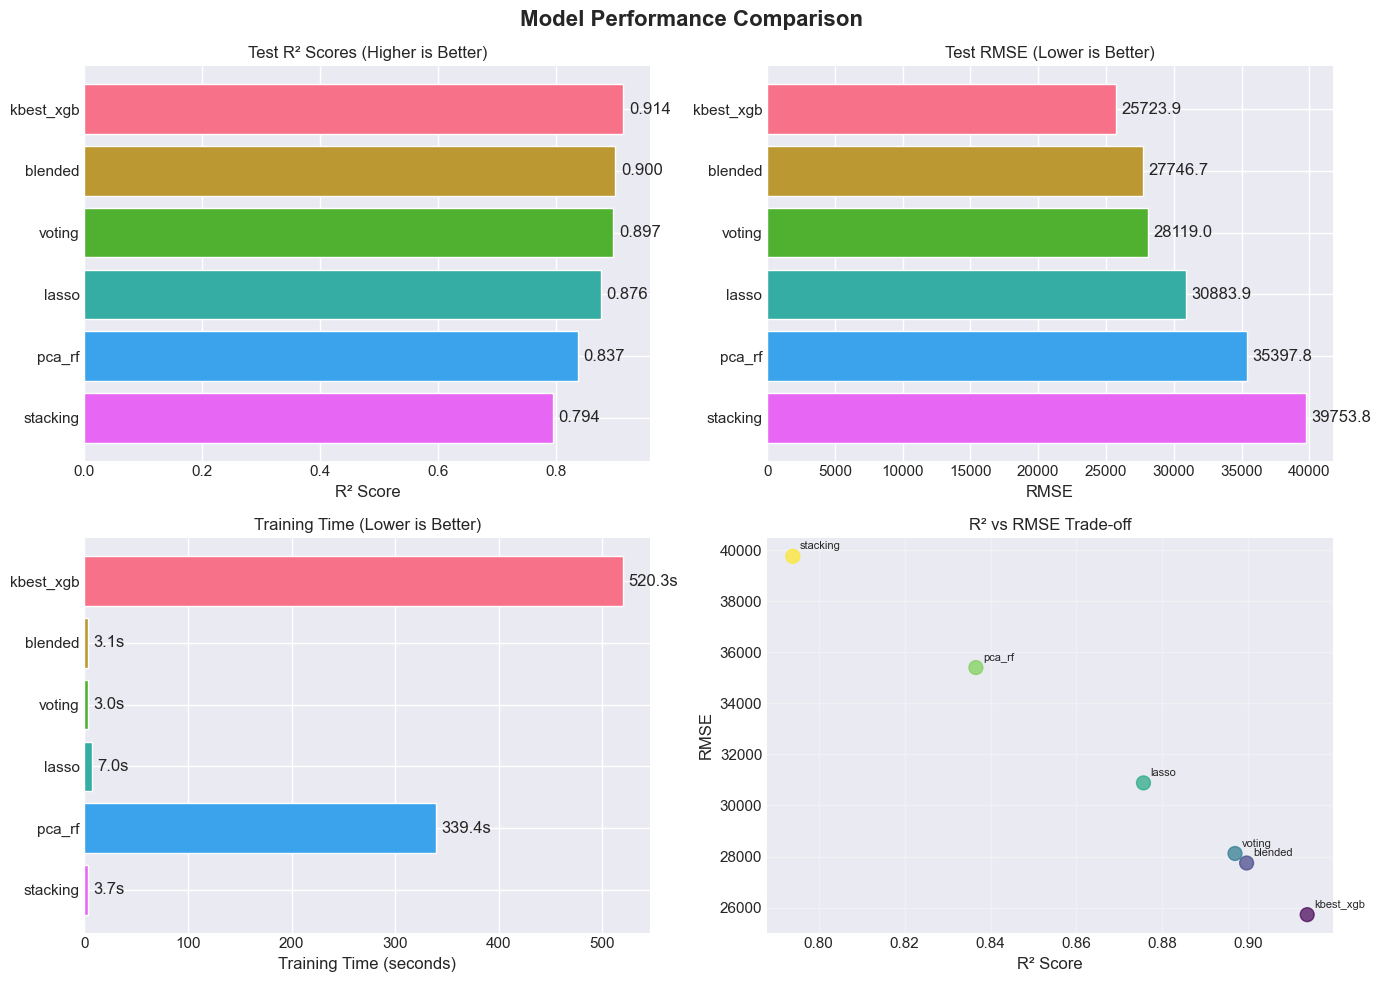

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold')

# 1. R² Scores
ax1 = axes[0, 0]
models = comparison_df['Model'].tolist()
r2_scores = [float(x) for x in comparison_df['Test R²']]
bars = ax1.barh(models, r2_scores, color=sns.color_palette("husl", len(models)))
ax1.set_xlabel('R² Score')
ax1.set_title('Test R² Scores (Higher is Better)')
ax1.invert_yaxis()  # Highest on top
for i, (bar, score) in enumerate(zip(bars, r2_scores)):
    ax1.text(score + 0.01, bar.get_y() + bar.get_height()/2, 
            f'{score:.3f}', va='center')

# 2. RMSE Scores
ax2 = axes[0, 1]
rmse_scores = [float(x) for x in comparison_df['Test RMSE']]
bars = ax2.barh(models, rmse_scores, color=sns.color_palette("husl", len(models)))
ax2.set_xlabel('RMSE')
ax2.set_title('Test RMSE (Lower is Better)')
ax2.invert_yaxis()
for i, (bar, score) in enumerate(zip(bars, rmse_scores)):
    ax2.text(score + max(rmse_scores)*0.01, bar.get_y() + bar.get_height()/2, 
            f'{score:.1f}', va='center')

# 3. Training Time
ax3 = axes[1, 0]
time_scores = []
for time_str in comparison_df['Train Time (s)']:
    if time_str != 'N/A':
        time_scores.append(float(time_str))
    else:
        time_scores.append(0)
bars = ax3.barh(models, time_scores, color=sns.color_palette("husl", len(models)))
ax3.set_xlabel('Training Time (seconds)')
ax3.set_title('Training Time (Lower is Better)')
ax3.invert_yaxis()
for i, (bar, time_val) in enumerate(zip(bars, time_scores)):
    if time_val > 0:
        ax3.text(time_val + max(time_scores)*0.01, bar.get_y() + bar.get_height()/2, 
                f'{time_val:.1f}s', va='center')

# 4. R² vs RMSE scatter
ax4 = axes[1, 1]
scatter = ax4.scatter(r2_scores, rmse_scores, s=100, c=range(len(models)), 
                     cmap='viridis', alpha=0.7)
ax4.set_xlabel('R² Score')
ax4.set_ylabel('RMSE')
ax4.set_title('R² vs RMSE Trade-off')
ax4.grid(True, alpha=0.3)

# model labels to scatter plot
for i, (model, r2, rmse) in enumerate(zip(models, r2_scores, rmse_scores)):
    ax4.annotate(model, (r2, rmse), xytext=(5, 5), 
                textcoords='offset points', fontsize=8)

plt.tight_layout()
plt.show()